In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [16]:
#scan_name ="YAG_timingHe_12"
scan_name =""
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"
DIR = "/sf/alvra/data/p17589/raw/" + scan_name + "/"             #use this for a scan

#savedir = '/das/work/p18/p18182/Export_PNG/'

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
print (files_scan)
scan_range = '.'+files_scan[-1].split('.')[-2]
print (scan_range)

!ls -lah -rt $DIR_json | grep json
!hostname

['/sf/alvra/data/p17589/res/scan_info/.timescan_7124eV_20uJ_7_scan_info.json.swp']
.json
-rw-r--r--.  1 39147 p17589 3.8K Oct 28  2018 monoscan_test_scan_info.json
-rw-r--r--.  1 39147 p17589 3.9K Oct 28  2018 monoscan_test_2_scan_info.json
-rw-r--r--.  1 39147 p17589 3.9K Oct 28  2018 monoscan_test_3_scan_info.json
-rw-r--r--.  1 39147 p17589 6.2K Oct 28  2018 monoscan_20uJ)170mm_Febpy_scan_info.json
-rw-r--r--.  1 39147 p17589 6.2K Oct 28  2018 monoscan_20uJ_170mm_Febpy_scan_info.json
-rw-r--r--.  1 39147 p17589 6.3K Oct 28  2018 monoscan_20uJ_170mm_Febpy_a_scan_info.json
-rw-r--r--.  1 39147 p17589 5.7K Oct 28  2018 timescan_7125eV_20uJ_scan_info.json
-rw-r--r--.  1 39147 p17589 6.9K Oct 28  2018 monoscan_20uJ_170mm_Febpy_pre-edge_scan_info.json
-rw-r--r--.  1 39147 p17589 3.9K Oct 28  2018 timescan_7124eV_20uJ_2_scan_info.json
-rw-r--r--.  1 39147 p17589 4.1K Oct 28  2018 timescan_7124eV_20uJ_3_scan_info.json
-rw-r--r--.  1 39147 p17589 4.1K Oct 28  2018 timescan_7124eV_20uJ_4_scan

ra-c-003.psi.ch


### Next cell: Signal calculated Shot-to-shot and averaged

In [42]:
quantile_laser = 0.68

channel_list_pp = [channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp  + [channel_Izero122, channel_delay]

########################################################################
json_file = DIR_json + "scan0004_2020-07-03-YAG_2_scan_info.json"
#json_file = DIR_json + scan_name + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe_all = []
Pump_probe = []
Pump_probe_avg =[]
Delay_mm = []

for i in range(0,numFiles):
    filename = (data['scan_files'][i])
    testdata = check_files_and_data(filename[0])

    if (testdata):# and (i!=12):
        clear_output(wait=True)
       
        print("step",i+1,"of",numFiles,": Processing %s" % (filename))
        
        resultsPP, results = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename[0])
        
        #(Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        #load_YAG_events(str(data['scan_files'][i][0]))
        Delay_shot = results[channel_delay]
        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        
        Izero_FEL = results[channel_Izero122]
        
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
        #Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        #Delay_mm.append(data['scan_readbacks'][i]) ## Delay from the json file

        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.median(Delay_shot))
        
        
Pump_probe_all = np.asarray(Pump_probe_all)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)

minlen = min(len(i) for i in Pump_probe_all)
def cut(arr, minlen):
    return np.array([i[:minlen] for i in arr])
Pump_probe_all = cut(Pump_probe_all, minlen)


Delay_mm = np.asarray(Delay_mm)
print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))
print ("Shape of pump probe data is {}".format(Pump_probe_all.shape))


step 16 of 41 : Processing ['/sf/alvra/data/p17589/raw/scan_data/scan0004_2020-07-03-YAG_2/scan0004_2020-07-03-YAG_2_step0015/run_000868.*.h5']

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (500,) and unpump = (500,) shots
PBPS data of the last step have 500 shots, avg intensity = 0.9866 +/- 0.0407
Quantile range = 0.15999999999999998 0.8400000000000001
Loaded 41 files, size of the arrays = 16
Shape of pump probe data is (16, 500)


 ### Plot pump probe signals as a function of delay (stage mm)

<IPython.core.display.Javascript object>


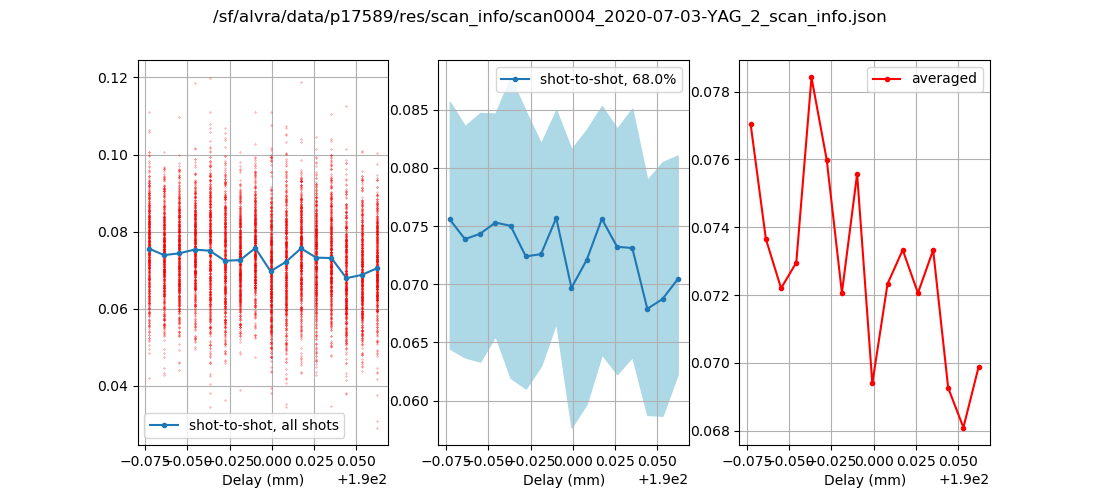

In [31]:
pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]
#err_pp_low = pp - abs(Pump_probe[:,1]/np.sqrt(len(Laser_diff)))
#err_pp_high = pp + abs(Pump_probe[:,2]/np.sqrt(len(Laser_diff)))

plt.figure(figsize = (11,5))
plt.suptitle (json_file)
plt.subplot(131)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, all shots', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
plt.grid()

plt.subplot(132)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_laser*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
#plt.xlim(190.05,190.1)
plt.grid()

plt.subplot(133)
plt.plot(Delay_mm, Pump_probe_avg, label="averaged", color = 'r', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig (savedir + scan_name + 'raw_scan.png')

 ### Extract t0 from the fit 

In [28]:
# Get a rough estimate of timezero in mm from the plot just above.
Timezero = 190.1

Pump_probe_toFit = pp.copy()
Delay_mm_toFit = np.copy(Delay_mm.T[0])
Delay_ps_toFit = (Delay_mm_toFit - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

In [30]:
# Now fit with error funciton
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.02, Timezero, 10])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

Position t0 = 190.10776 mm
Width = 2.0 um


In [31]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_ps_toFit) | np.isnan(Pump_probe_toFit))
parameters_ps,extras = curve_fit(errfunc_fwhm, Delay_ps_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.2, 0, 100])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,5))*1000,"fs")

Position t0 = 0.05135 ps
Width = 12.7 fs


<IPython.core.display.Javascript object>


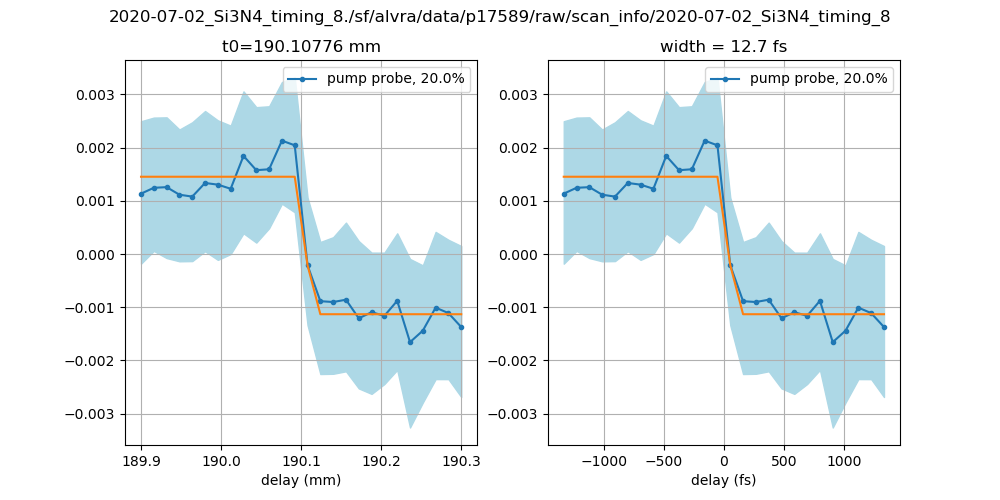

t0 = 190.10776 mm


In [32]:
#... and the plot with the fit curves

plt.figure(figsize = (10,5))
plt.suptitle (scan_name + scan_range)
plt.subplot(121)

plt.plot(Delay_mm_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_mm_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_mm_toFit, errfunc_fwhm(Delay_mm_toFit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_ps_toFit*1000, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_ps_toFit*1000, errfunc_fwhm(Delay_ps_toFit,*parameters_ps))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_ps, 5))*1000))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
plt.show()
#plt.savefig (savedir + scan_name + 'fit.png')

# From here with TT (PALM) jitter correction

In [16]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-01-25_16:28:32.palm_etof'

energyFrom =  8400
energyTo =    8600
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))


palm.load_etof_calib(CalibrationFn)

In [33]:
channel_list_pp = [channel_LaserDiode, channel_Laser_refDiode, channel_PALM_streak, channel_PALM_unstreak, channel_Izero122]
channel_list_all = channel_list_pp  + [channel_Events, channel_delay]

quantile_laser = 0.5
ev2fsCalib= -20.723024835035712    # This is from THz scan_508
Timezero = 163.04579              # This is from above
#modulo = 2                        # This is for FEL/50Hz -- laser/100Hz
                
########################################################################


###########################################################################################
json_file = DIR_json + scan_name + scan_range + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
Pump_probe_avg =[]
Pump_probe_all = []
Delays_stage_mm = []
Delays_PALM_all = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    testdata = check_files_and_data(filename)

    if (testdata):# and (i!=12):
 #       clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    
        results_pp, results_all = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, filename)
        
        Laser_pump = results_pp[channel_LaserDiode].pump
        Laser_unpump = results_pp[channel_LaserDiode].unpump
        TOF = results_pp[channel_PALM_streak].pump
        uTOF = results_pp[channel_PALM_unstreak].pump
        Izero_FEL = results_pp[channel_Izero122].pump
        Event_code = results_all[channel_Events]
        
        FEL = Event_code[:,12] #Event 12: BAM bunch 1
        Laser = Event_code[:,18]
        Darkshot = Event_code[:,21]
        
        prep_data = {"0":uTOF, "1":TOF}
        delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process(prep_data, debug=True)
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
        fullArraySize = len(TOF)
        
        beamOK = (Izero_FEL > 0)
            
        delays_beamOK = delays_PALM_fs[beamOK]
        NumberOK = len(delays_beamOK) 
        shots2pad = fullArraySize - NumberOK
        FEL_reprate = 100 / (1 / FEL.mean()).round().astype(int)
        if Darkshot.mean()==0:
            ratio = Laser.mean().round().astype(int)
        else:
            ratio = (Laser.mean() / Darkshot.mean() - 1).round().astype(int)
        print ('FEL @ {} Hz, ratio light/dark = {}:1, light shots are {}'.format(FEL_reprate, ratio, NumberOK))
        
        try:       
            delays_beamOK = np.pad(delays_beamOK, (0, shots2pad), constant_values=np.NaN)
            Laser_diff = np.pad(Laser_diff, (0, len(delays_beamOK)-len(Laser_diff)), constant_values=np.NaN)
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, light shots are {}, need to pad {} shots' \
                   .format(ratio, FEL_reprate, NumberOK, shots2pad))
        except:
            print ('Ratio light/dark is {}:1 at pump rep rate {} Hz, they are not commensurate, cannot pad. Keep {} light shots' \
                   .format(ratio, FEL_reprate, NumberOK))
                       
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.quantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        Delays_PALM_all.append(delays_beamOK)
        
        Pump_probe_all.append(Laser_diff)

Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)
        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))

Processing 61 files
/sf/alvra/data/p18182/res/scan_info/SiN_timingHe_3.run000384-000445.json
step 1 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000384.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 10 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000393.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 19 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000402.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 28 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000411.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 38 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000421.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 47 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000430.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark is 1:1 at pump rep rate 50.0 Hz, light shots are 249, need to pad 0 shots
step 56 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000439.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 499 / 499 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 499 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (laser) is 100.0 Hz
Loaded pump = (249,) and unpump = (249,) shots
1.0 0.0
FEL @ 50.0 Hz, ratio light/dark = 1:1, light shots are 249
Ratio light/dark 

In [34]:
print (Delays_PALM_all.shape, Pump_probe_all.shape, Delays_stage_mm.shape)

(60, 249) (60, 249) (60, 1)


<IPython.core.display.Javascript object>


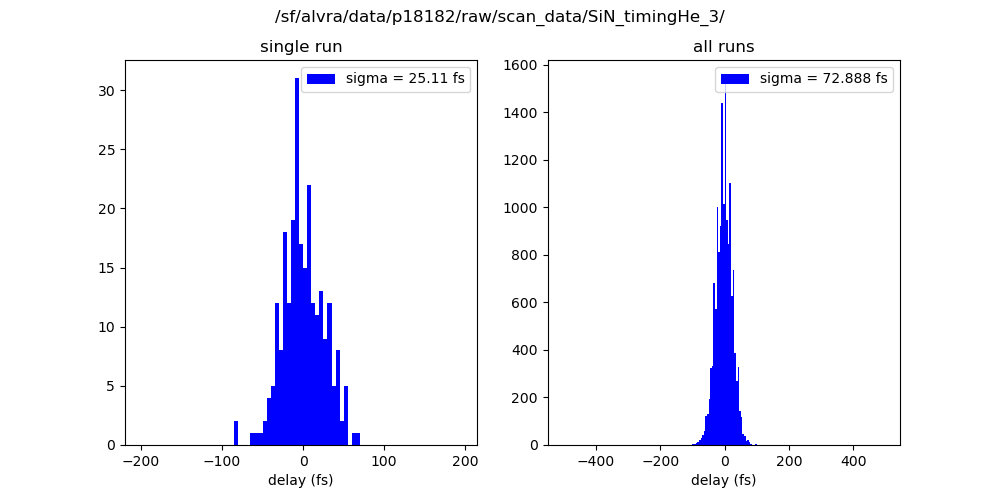

In [35]:
plt.figure(figsize=(10,5))
plt.suptitle(DIR)

plt.subplot(121)
plt.hist((Delays_PALM_all[0,:]-np.nanmean(Delays_PALM_all[0])), bins =np.arange(-200,200,5), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all[0,:]-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.title('single run')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

plt.subplot(122)
plt.hist((Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all)), bins =np.arange(-500,500,5), facecolor='blue', \
         label="sigma = {} fs".format(np.round(np.nanstd(Delays_PALM_all.ravel()-np.nanmean(Delays_PALM_all)), 3), alpha=0.5))
plt.title('all runs')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()
plt.savefig (savedir + scan_name + 'TT_hist.png')

In [36]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs + ((DelaysPALM_fs)-(np.nanmean(DelaysPALM_fs)))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    
    digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    signalProc = []
    signalProc_Q = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i+1
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        df_signal = pd.DataFrame(Signal[ind])
        signalProc_Q.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
        
    signalProc= np.array(signalProc)
    signalProc_Q= np.array(signalProc_Q)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)

    return binsCentre, CorrectedTime, signalProc, signalProc_Q, signalProcSS, Num_points

In [37]:
quantile_reBin = 0.5
reBin_factor = 4

############################################################################

BinsCentre, CorrectedTime, Signal, Signal_Q, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

(60, 249) (60, 1) (14940,)


In [38]:
print (Signal.shape, Signal_Q.shape)

(240,) (240, 3)


<IPython.core.display.Javascript object>


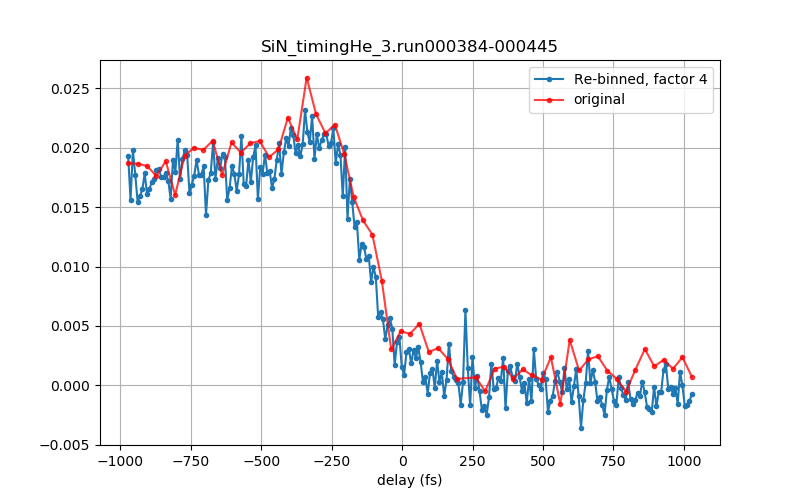

In [39]:
sig = Signal
plt.figure(figsize = (8,5))
plt.title (scan_name + scan_range)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}'.format(reBin_factor), marker = '.')

plt.plot(Delays_stage_fs, pp, label='original', color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
plt.show()
#plt.savefig (savedir + scan_name + 'TT_rebin.png')

In [ ]:
sig = Signal_Q[:,0]
err_sig_low = Signal_Q[:,1]
err_sig_high = Signal_Q[:,2]

plt.figure(figsize = (8,5))
plt.title (scan_name + scan_range)

#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre.ravel(), sig, label='Re-binned, factor {}, {}%  '.format(reBin_factor, quantile_reBin*100), marker = '.')
plt.fill_between(BinsCentre.ravel(), err_sig_low, err_sig_high, color='lightblue',  alpha = 0.5)

plt.plot(Delays_stage_fs, pp, label='original, {}%'.format(quantile_laser*100), color = 'r', marker='.', alpha = 0.75)
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)

plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
plt.show()
plt.savefig (savedir + scan_name + 'TT_rebin.png')

In [ ]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(BinsCentre.ravel()) | np.isnan(sig))
parameters_ps,extras = curve_fit(errfunc_fwhm, BinsCentre.ravel()[index], sig[index], p0 = [0, 0.2, 0, 100])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,5)),"fs")

In [ ]:
print (Delays_stage_fs[1]-Delays_stage_fs[0])

In [ ]:
time_zero =  149.6658   #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 3        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

In [50]:
offset_space = 200       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 200 um corresponds to an offset of 1333.3333 fs


In [65]:
offset_time = 20      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 20 fs corresponds to an offset of 3.0 um


In [ ]:
195.2-(105.9-88.35)

In [ ]:
# Check if the condition on the intensity makes sense by looking at the total histogram. §

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()